In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:

path = '/Users/sumairshaik/Downloads/lfw-2'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


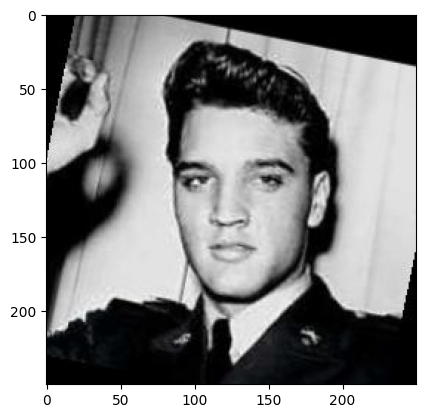

In [78]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
# Import necessary libraries
import torch

# sample batch from the dataloader
sample_batch, sample_labels = next(iter(dataloader))

# Print dimensions
print("Batch Dimensions:", sample_batch[0].shape)


Batch Dimensions: torch.Size([3, 250, 250])


In [7]:
# Explaining each dimension
num_channels, height, width = sample_batch[0].size()

print("Number of Channels (Color Channels):", num_channels)
print("Image Height:", height)
print("Image Width:", width)

Number of Channels (Color Channels): 3
Image Height: 250
Image Width: 250


* channels is the number of color channels in each image (3 for RGB).
250 is the height of each image.
second 250 is the width of each image

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
import torch
import torch.nn as nn

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        
        # Encoder layers
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        # Decoder layers
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=1, padding=3),
            nn.Sigmoid() 
        )

    def encoder(self, x):
        return self.encoder_layers(x)

    def decoder(self, x):
        return self.decoder_layers(x)

    def forward(self, x):
        # Forward pass through encoder and decoder functions
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [9]:
model = AE()

In [10]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Using the first image from the batch as a sample
sample_image = sample_batch[0:1] 

print("Sample image shape:", sample_image.shape)

# Extract encoder and decoder outputs
encoded_output = model.encoder(sample_image)
decoded_output = model.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print("Encoder Output Shape:", encoded_output.shape)
print("Decoder Output Shape:", decoded_output.shape)


Sample image shape: torch.Size([1, 3, 250, 250])
Encoder Output Shape: torch.Size([1, 64, 32, 32])
Decoder Output Shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters: {total_params}")


Total Number of Parameters: 62891


In [12]:
loss_function = nn.MSELoss()

The goal is to reduce differences on a per-pixel basis. The Mean Squared Error (MSE) loss specifically tackles variations in pixel values between the original and reconstructed images by calculating the average squared distances. By minimizing this loss, the model is prompted to generate a more precise reconstructed image that closely aligns with the input image

In [13]:
import torch.optim as optim

optim = optim.Adam(model.parameters(), lr=0.01)


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
model.to(device)

num_epochs = 10 

for epoch in range(num_epochs):
    total_loss = 0.0
    
    for batch_data, _ in dataloader:
        # Zero the gradients
        optim.zero_grad()

        batch_data = batch_data.to(device)
        # Forward pass
        outputs = model(batch_data)

        # Compute the loss
        loss = loss_function(outputs, batch_data)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        total_loss += loss.item()
    
    # Print average loss at the end of each epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")


Epoch [1/10], Loss: 0.006657495345033993
Epoch [2/10], Loss: 0.002314882759558226
Epoch [3/10], Loss: 0.001647727015081811
Epoch [4/10], Loss: 0.0013269775632570907
Epoch [5/10], Loss: 0.0011595420828730246
Epoch [6/10], Loss: 0.0010842614581387778
Epoch [7/10], Loss: 0.0009180861115393764
Epoch [8/10], Loss: 0.0008402063837781062
Epoch [9/10], Loss: 0.0007803508395903883
Epoch [10/10], Loss: 0.0008095782190411698


If the loss is not decreasing, several strategies can be employed based on the underlying issue. Some of them are:

1. **Adjusting Learning Rate**: If the learning rate is inappropriate, the loss may plateau. In such cases, consider modifying the learning rate or implementing a learning rate scheduler to automatically update it after each epoch.
2. **Enhancing Model Complexity**: If the model proves too simplistic for a complex task, it may struggle to capture intricate patterns, resulting in a stagnant loss. Experiment by adding more layers and increasing the model's depth to improve its ability to comprehend input features.
3. **Choosing different Optimizer**: Different optimizers may yield varying performance on different models. Experiment with various optimizers to find the one that best suits the specific requirements of the model.
4. **Avoiding Over Compression**: Excessive compression during the encoder phase can make it challenging for the decoder to restore the input to its original dimension, causing the loss to plateau. Adjust compression levels to strike a balance and prevent over-compression

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

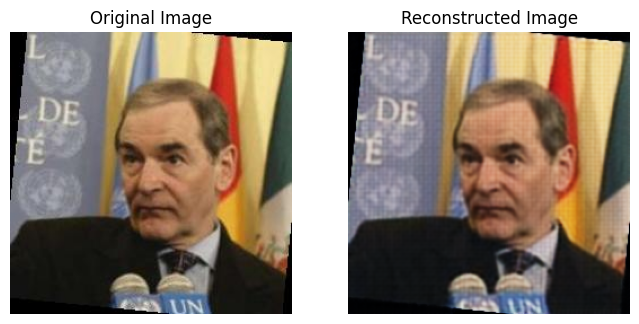

In [83]:
import matplotlib.pyplot as plt
import random

model.eval()

# Choosing a random image from the dataset
sample_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[sample_index]

# Adding a batch dimension to the sample image
sample_image = sample_image.unsqueeze(0).to(device)

# Doing Forward pass through the autoencoder
reconstructed_image = model(sample_image)

# Removing the batch dimension from the reconstructed image
reconstructed_image = reconstructed_image.cpu().squeeze(0).detach().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image.cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.transpose(1, 2, 0))
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

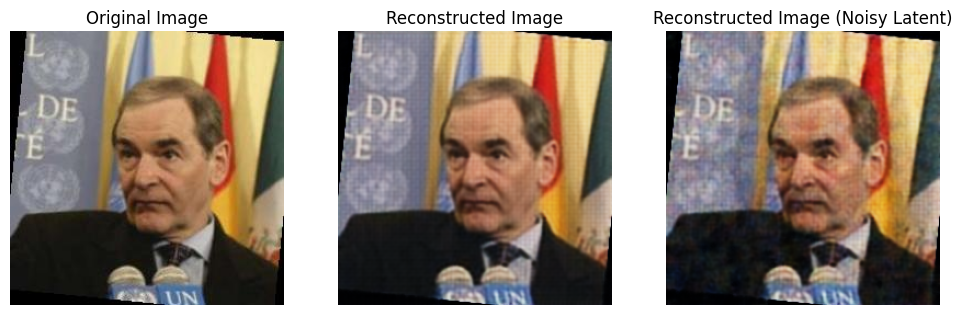

In [84]:
import torch
import matplotlib.pyplot as plt
import random

model.eval()

# Doing Forward pass through the encoder to get the latent representation
latent_representation = model.encoder(sample_image)

# Adding small normally distributed noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.4 
noisy_latent_representation = latent_representation + noise

# Forward pass through the decoder with the noisy latent representation
reconstructed_image_with_noise = model.decoder(noisy_latent_representation)

# Removing the batch dimension from the tensors for plotting
sample_image = sample_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
reconstructed_image_with_noise = reconstructed_image_with_noise.cpu().squeeze(0).permute(1, 2, 0).detach().numpy()

# Plotting the original and reconstructed images with noise
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image.transpose(1, 2, 0))  # Assuming the image is in the format (C, H, W)
plt.axis('off')

# Reconstructed Image (Noisy Latent)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image (Noisy Latent)")
plt.imshow(reconstructed_image_with_noise)
plt.axis('off')

plt.show()


When random noise is introduced to the condensed representation created by the encoder, it impairs the model's ability to faithfully reproduce the original image. The encoder excels at compressing input details into a confined space. However, altering this representation with noise after training disrupts the meaningful patterns the encoder has captured, resulting in distortions in the reconstructed output.